# Meta-SGD Evaluation of Untrained TTT model

This notebook instantiates a TTT differentiable memory with its weights fixed to one and evaluates recall quality after inner-loop updates with the ManualSGD meta-optimizer across different learning rates.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from func_memory_module import TTT, OuterProductMemory
from meta_optimizers import ManualSGD
from losses import windowed_p_loss
from synthetic_datasets import InContextRecallDataset
from evaluate_functions import (
    average_accuracy_across_sequences,
    average_correct_retrievals_across_sequences,
    compute_recall_accuracies,
)
from torch.func import functional_call


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
key_dim = 10
val_dim = 10
context_size = 5
sequence_length = 100
momentum = 0
learning_rates = [0.05,0.1,0.15]
num_sequences = 100
num_layers = 1
datasets = [
    InContextRecallDataset(
        seq_len=sequence_length,
        key_dim=key_dim,
        val_dim=val_dim,
        context_size=context_size,
    )
    for _ in range(num_sequences)
]


In [ ]:
def create_memory_module(
    key_dim: int,
    val_dim: int,
    num_layers: int,
    device: torch.device,
) -> TTT:
    """Instantiate a memory module with deterministic weights on the target device."""
    module = TTT(key_dim, val_dim, num_layers=num_layers)
    module = module.to(device)
    with torch.no_grad():
        for parameter in module.parameters():
            parameter.fill_(1.0)
    module.train()
    return module


def make_functional_params(module: TTT) -> dict[str, torch.Tensor]:
    """Clone module parameters into a dict suitable for ``functional_call``."""
    return {
        name: param.detach().clone().requires_grad_(True)
        for name, param in module.named_parameters()
    }


def detach_params_for_next_step(params: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
    """Detach optimizer outputs so they act as fresh leaf tensors on the next step."""
    return {
        name: tensor.detach().clone().requires_grad_(True)
        for name, tensor in params.items()
    }


def detach_params_for_eval(params: dict[str, torch.Tensor]) -> dict[str, torch.Tensor]:
    """Detach parameters for evaluation (no gradient tracking)."""
    return {name: tensor.detach().clone() for name, tensor in params.items()}


def adapt_with_meta_sgd(
    module: TTT,
    dataset: InContextRecallDataset,
    lr: float,
    momentum: float = momentum,
) -> tuple[dict[str, torch.Tensor], list[torch.Tensor], torch.Tensor]:
    inner_opt = ManualSGD()
    params = make_functional_params(module)
    state = inner_opt.init_states(params)
    state = {"v": {name: buf.detach().clone() for name, buf in state["v"].items()}}

    full_keys = dataset.inputs.to(device)
    full_values = dataset.targets.to(device)

    accuracy_history: list[torch.Tensor] = []
    retrieval_counts: list[torch.Tensor] = []

    for t in range(len(dataset)):
        key_window, value_window = dataset[t]
        key_window = key_window.to(device)
        value_window = value_window.to(device)

        predictions = functional_call(module, params, key_window)
        loss = windowed_p_loss(predictions.T, value_window.T)

        param_items = list(params.items())
        grads_tuple = torch.autograd.grad(
            loss,
            tuple(p for _, p in param_items),
            allow_unused=True,
        )
        grads = {}
        for (name, param), grad in zip(param_items, grads_tuple):
            grads[name] = torch.zeros_like(param) if grad is None else grad

        updated_params, updated_state = inner_opt.step(
            params,
            grads,
            state,
            lr=lr,
            beta=momentum,
        )

        params = detach_params_for_next_step(updated_params)
        state = {"v": {name: buf.detach().clone() for name, buf in updated_state["v"].items()}}

        with torch.no_grad():
            window_keys = full_keys[: t + 1]
            window_values = full_values[: t + 1]
            eval_predictions = functional_call(module, params, window_keys)
            logits = eval_predictions @ window_values.T
            predicted_indices = logits.argmax(dim=-1)
            target_indices = torch.arange(t + 1, device=predicted_indices.device)
            per_key_accuracy = (predicted_indices == target_indices).to(torch.float32)
            accuracy_history.append(per_key_accuracy.flip(0))
            retrieval_counts.append(per_key_accuracy.sum())

    final_params = detach_params_for_eval(params)
    retrieval_tensor = (
        torch.stack(retrieval_counts)
        if retrieval_counts
        else torch.empty(0, dtype=torch.float32, device=device)
    )
    return final_params, accuracy_history, retrieval_tensor


def evaluate_learning_rate(lr: float) -> tuple[list[list[torch.Tensor]], list[torch.Tensor]]:
    accuracy_histories: list[list[torch.Tensor]] = []
    retrieval_histories: list[torch.Tensor] = []
    for dataset in datasets:
        module = create_memory_module(key_dim, val_dim, num_layers=num_layers, device=device)
        _, accuracy_history, retrieval_counts = adapt_with_meta_sgd(
            module,
            dataset,
            lr,
            momentum=momentum,
        )
        accuracy_histories.append(accuracy_history)
        retrieval_histories.append(retrieval_counts)
    return accuracy_histories, retrieval_histories

def retrieval_tensors_to_histories(
    retrieval_histories: list[torch.Tensor],
) -> list[list[torch.Tensor]]:
    """Convert per-sequence retrieval tensors into histories for aggregation."""
    histories: list[list[torch.Tensor]] = []
    for tensor in retrieval_histories:
        histories.append([tensor])
    return histories

def compute_outer_product_histories(
    dataset: InContextRecallDataset,
) -> tuple[list[torch.Tensor], torch.Tensor]:
    """Evaluate outer product baseline using the general compute_recall_accuracies function."""
    # Create the outer product memory module
    memory_module = OuterProductMemory(
        key_dim=key_dim,
        val_dim=val_dim,
        device=device
    )

    # Update the memory module with each key-value pair
    with torch.no_grad():
        for t in range(len(dataset)):
            key_t, value_t = dataset[t]
            memory_module.update(key_t.to(device), value_t.to(device))

    # Use the general evaluation function
    accuracy_history = compute_recall_accuracies(memory_module, dataset.inputs, dataset.targets)

    # Compute retrieval counts (same logic as before)
    retrieval_counts = []
    for offset_tensor in accuracy_history:
        retrieval_counts.append(offset_tensor.sum())

    retrieval_tensor = (
        torch.stack(retrieval_counts)
        if retrieval_counts
        else torch.empty(0, dtype=torch.float32, device=device)
    )

    return accuracy_history, retrieval_tensor



evaluations_by_lr = {lr: evaluate_learning_rate(lr) for lr in learning_rates}
outer_product_evaluations = [
    compute_outer_product_histories(dataset) for dataset in datasets
]
print(
    "Computed recall histories and retrieval counts for each learning rate and outer-product baseline"
)


Computed recall histories and retrieval counts for each learning rate and outer-product baseline


In [7]:
accuracy_by_model: dict[str, tuple[torch.Tensor, torch.Tensor]] = {}
retrievals_by_model: dict[str, tuple[torch.Tensor, torch.Tensor]] = {}
plot_labels: list[str] = []

for lr, (accuracy_histories, retrieval_histories) in evaluations_by_lr.items():
    label = f"Meta-SGD lr={lr}"
    mean_accuracy, counts = average_accuracy_across_sequences(accuracy_histories)
    mean_retrievals, retrieval_counts = average_correct_retrievals_across_sequences(
        retrieval_tensors_to_histories(retrieval_histories)
    )
    accuracy_by_model[label] = (mean_accuracy.cpu(), counts.cpu())
    retrievals_by_model[label] = (mean_retrievals.cpu(), retrieval_counts.cpu())
    plot_labels.append(label)

outer_product_accuracy_histories = [history for history, _ in outer_product_evaluations]
outer_product_retrieval_histories = [counts for _, counts in outer_product_evaluations]

dw_label = "Outer-product sum"
mean_accuracy, counts = average_accuracy_across_sequences(outer_product_accuracy_histories)
mean_retrievals, retrieval_counts = average_correct_retrievals_across_sequences(
    retrieval_tensors_to_histories(outer_product_retrieval_histories)
)
accuracy_by_model[dw_label] = (mean_accuracy.cpu(), counts.cpu())
retrievals_by_model[dw_label] = (mean_retrievals.cpu(), retrieval_counts.cpu())
plot_labels.append(dw_label)

for label in plot_labels:
    mean_accuracy, _ = accuracy_by_model[label]
    print(f"{label} | Offset 0 accuracy: {mean_accuracy[0].item():.3f}")


Meta-SGD lr=0.05 | Offset 0 accuracy: 0.105
Meta-SGD lr=0.1 | Offset 0 accuracy: 0.354
Meta-SGD lr=0.15 | Offset 0 accuracy: 0.650
Outer-product sum | Offset 0 accuracy: 0.289


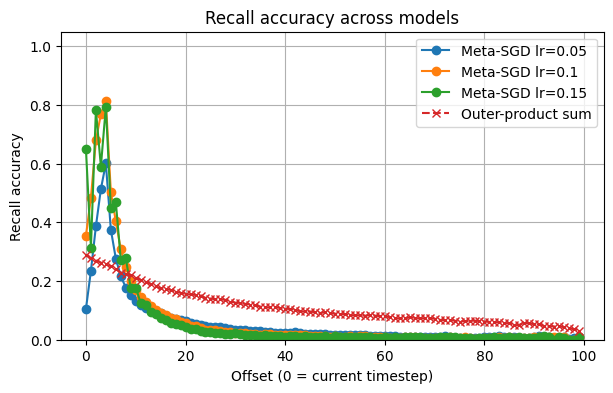

In [8]:
plt.figure(figsize=(7, 4))
for label in plot_labels:
    mean_accuracy, counts = accuracy_by_model[label]
    offsets = np.arange(mean_accuracy.shape[0])
    mask = counts.numpy() > 0
    style = {"marker": "o"}
    if label == dw_label:
        style.update({"linestyle": "--", "marker": "x"})
    plt.plot(offsets[mask], mean_accuracy.numpy()[mask], label=label, **style)

plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy across models")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.show()



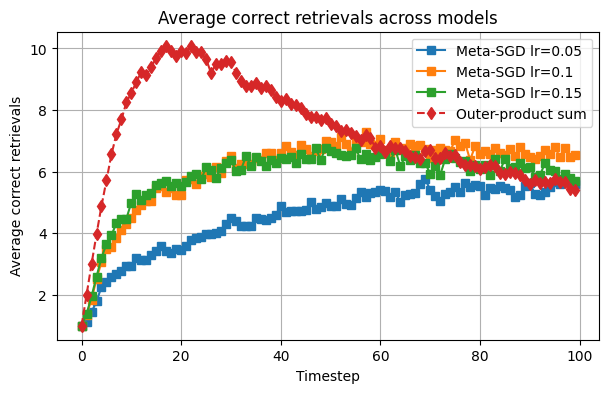

In [9]:
plt.figure(figsize=(7, 4))
for label in plot_labels:
    mean_retrievals, counts = retrievals_by_model[label]
    timesteps = np.arange(mean_retrievals.shape[0])
    mask = counts.numpy() > 0
    style = {"marker": "s"}
    if label == dw_label:
        style.update({"linestyle": "--", "marker": "d"})
    plt.plot(timesteps[mask], mean_retrievals.numpy()[mask], label=label, **style)

plt.xlabel("Timestep")
plt.ylabel("Average correct retrievals")
plt.title("Average correct retrievals across models")
plt.grid(True)
plt.legend()
plt.show()

